# GPU accelerated dose response curve fitting

## Is this necessary?
Not at all.

## Is this useful?
No, use `scipy.optimize.curve_fit`.

In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"

def load_data():
    df = pd.read_csv("./raw_data.csv")
    df = df.dropna(axis=0)
    return df


class DoseResponse(torch.nn.Module):
    """4 parameter dose response curve"""
    def __init__(self):
        super().__init__()
        weights = torch.distributions.Uniform(0, 0.1).sample((4,))
        self.weights = torch.nn.Parameter(weights)

    def forward(self, x):
        top, bottom, ec50, hill_slope = self.weights
        return (top - bottom) / (1 + (x / ec50) ** hill_slope)


def train(model, optimiser, n=100000):
    losses = []
    x = torch.tensor(df["dilution"].values).to(device)
    y = torch.tensor(df["percentage_infected"].values).to(device)
    for i in range(n):
        preds = model(x)
        loss = F.mse_loss(preds, y) / len(x)
        if i % 10000 == 0:
            print(f"{i:05}, {loss.item():.4f}")
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        losses.append(loss)
    return losses, model


df = load_data()

model = DoseResponse()
model = model.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
losses, fitted_model = train(model, optimiser)

top, bottom, ec50, hill_slope = model.weights.data.numpy()
print(top, bottom, ec50, hill_slope)

00000, 4.4296
10000, 2.4692
20000, 1.2339
30000, 0.5255
40000, 0.3120
50000, 0.1975
60000, 0.1959
70000, 0.1960
80000, 0.1959
90000, 0.1959
46.561386 -46.50781 0.0025624454 1.4188955


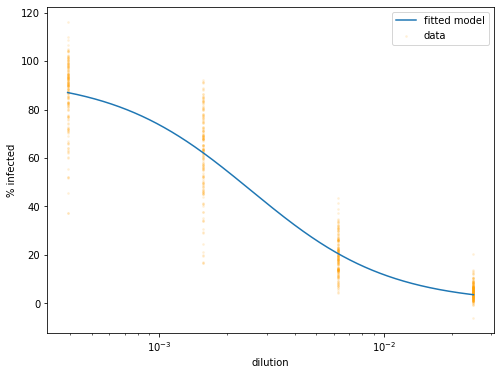

In [2]:
concs = np.linspace(df["dilution"].min(), df["dilution"].max(), 10000)
with torch.no_grad():
    yhat = fitted_model(concs).data.numpy()
    
plt.figure(figsize=[8, 6])
plt.scatter(df["dilution"], df["percentage_infected"], s=3, alpha=0.1, c="orange", label="data")
plt.plot(concs, yhat, label="fitted model")
plt.legend()
plt.xlabel("dilution")
plt.ylabel("% infected")
plt.xscale("log")
plt.show()